In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [96]:
# Load and process data
data = pd.read_csv('personalitytest24.csv')

for i in data.columns:
    if 'Unn' in i: del data[i]
        
age = data.pop('Age')
age.fillna(age.median(), inplace=True)
data.fillna(data.mean(), inplace=True)

def absolute_correlations(col, df=data, threshold=.5):
    '''Finds related questions, with both positive and negative correlations'''
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs[corrs.absol > threshold].sort_values('absol', ascending=False).drop('absol', axis=1)

def rev(item):
    '''Questions are scored out of 7, and many need to be reverse-scored'''
    return 8 - item

data.shape

(75, 56)

# Questions sorted by controversy

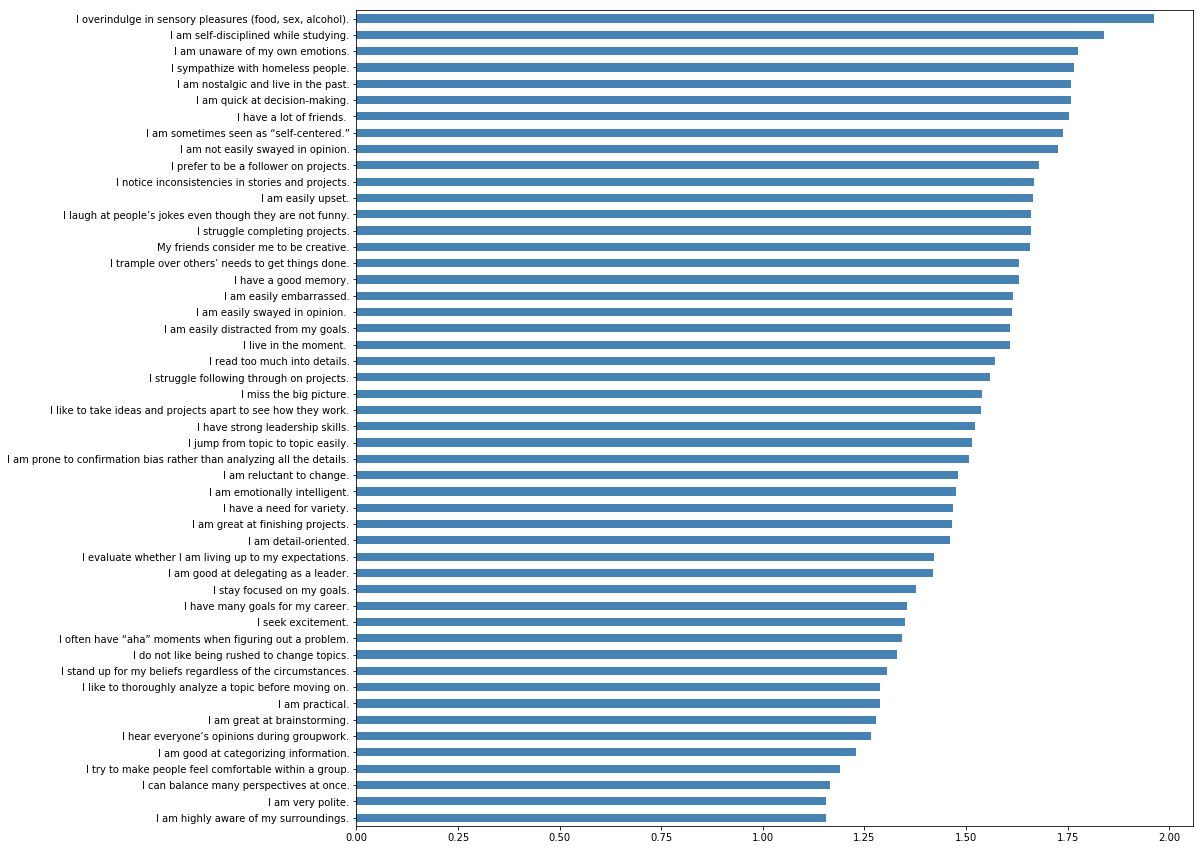

In [8]:
qs = data.select_dtypes(include=[np.number]).fillna(data.mean()).T

qs['stdev'] = qs.std(axis=1)

questions_sorted = qs.sort_values('stdev')['stdev'].index

# Most controversial at top; least controversial at bottom
qs['stdev'].sort_values().plot.barh(color='steelblue', figsize=(15,15))

# Correlations between questions

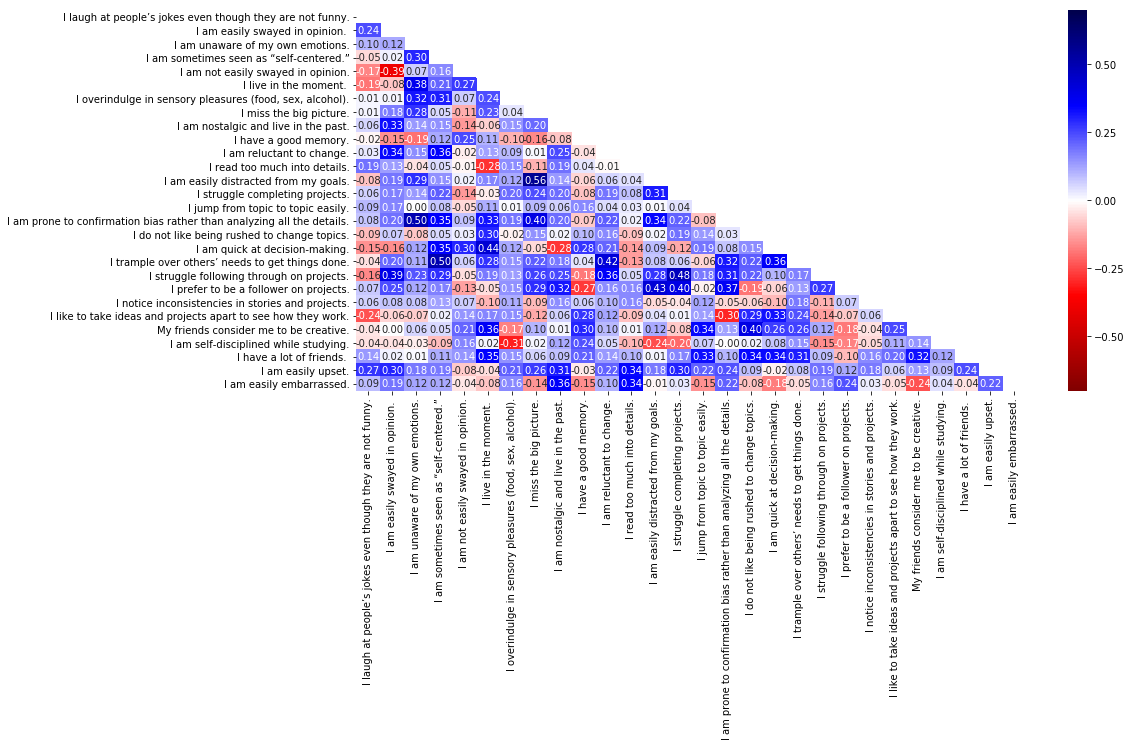

In [99]:
questions = [i for i in data.select_dtypes('number').columns if data[i].mean() >= 1 and data[i].mean() <= 5]
corrs = data[questions].corr()

def correlation_matrix(df, figsize=(15,7)):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Resize and display
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, fmt='.2f', mask=mask,
                vmin=-.7, vmax=.7, cmap='seismic_r')
    
correlation_matrix(data[questions])

# Factor analysis

A factor analysis is how you discover related questions (the Big Five is also called the Five Factor Model). Just for fun, let's try doing it with 5 personality traits first.

In [18]:
from sklearn.decomposition import FactorAnalysis

n_factors = 5

factor = FactorAnalysis(n_components=n_factors, random_state=1).fit(data.select_dtypes('number'))
factors = pd.DataFrame(factor.components_, columns=data.select_dtypes('number').columns).T

This is hard to interpret, but I did my best to make it readable. Factor loadings are similar to correlations but not quite the same thing. You want to look at the number furthest from zero to see what family of questions it belongs to most.

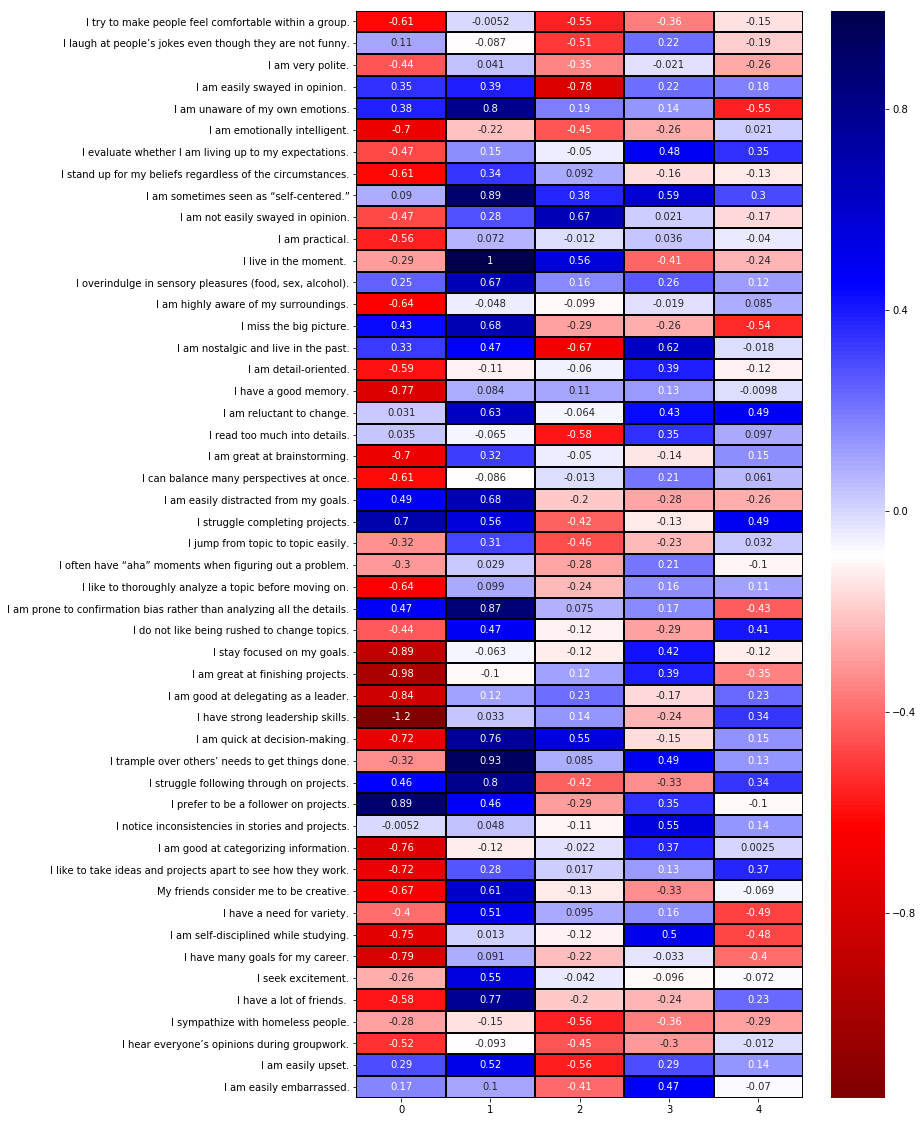

In [28]:
plt.figure(figsize=(10,20))
sns.heatmap(factors, annot=True, cmap='seismic_r', linewidths=1, linecolor='black')

Long story short, I analyzed it and 8 appears to be a better number than 5 for this data. So let's look at your 8 factors:

In [45]:
from sklearn.decomposition import FactorAnalysis

n_factors = 8

factor = FactorAnalysis(n_components=n_factors, random_state=1).fit(data.select_dtypes('number'))
factors = pd.DataFrame(factor.components_, columns=data.select_dtypes('number').columns).T

for i in range(n_factors):
    factors['factor_' + str(i) + '_abs'] = np.abs(factors[i])

factors.head()

,0,1,2,3,4,5,6,7,factor_0_abs,factor_1_abs,factor_2_abs,factor_3_abs,factor_4_abs,factor_5_abs,factor_6_abs,factor_7_abs
I try to make people feel comfortable within a group.,-0.616,0.049,-0.510,-0.494,-0.086,-0.019,-0.024,-0.247,0.616,0.049,0.510,0.494,0.086,0.019,0.024,0.247
I laugh at people’s jokes even though they are not funny.,0.093,-0.042,-0.587,0.094,-0.024,0.114,-0.195,-0.492,0.093,0.042,0.587,0.094,0.024,0.114,0.195,0.492
I am very polite.,-0.432,0.082,-0.359,-0.089,-0.209,-0.278,0.143,0.073,0.432,0.082,0.359,0.089,0.209,0.278,0.143,0.073
I am easily swayed in opinion.,0.354,0.436,-0.717,0.029,0.180,0.404,0.287,0.136,0.354,0.436,0.717,0.029,0.180,0.404,0.287,0.136
I am unaware of my own emotions.,0.414,0.773,0.183,0.153,-0.394,-0.110,-0.171,-0.532,0.414,0.773,0.183,0.153,0.394,0.110,0.171,0.532


In [47]:
# Remember these numbers aren't quite the same as correlations, but it's a similar idea
factors.sort_values('factor_0_abs', ascending=False)[[0]].head(10)

,0
I have strong leadership skills.,-1.203
I am great at finishing projects.,-0.952
I prefer to be a follower on projects.,0.939
I stay focused on my goals.,-0.902
I am good at delegating as a leader.,-0.837
I have many goals for my career.,-0.777
I have a good memory.,-0.765
I am good at categorizing information.,-0.761
I am self-disciplined while studying.,-0.752
I am emotionally intelligent.,-0.710


In [48]:
factors.sort_values('factor_1_abs', ascending=False)[[1]].head(10)

,1
I trample over others’ needs to get things done.,0.943
I live in the moment.,0.928
I am sometimes seen as “self-centered.”,0.865
I am prone to confirmation bias rather than analyzing all the details.,0.852
I have a lot of friends.,0.809
I struggle following through on projects.,0.783
I am unaware of my own emotions.,0.773
I am quick at decision-making.,0.753
I am easily distracted from my goals.,0.722
I miss the big picture.,0.708


In [49]:
# Notice the relationships are getting weaker and questions are repeating
factors.sort_values('factor_2_abs', ascending=False)[[2]].head(10)

,2
I am easily swayed in opinion.,-0.717
I am nostalgic and live in the past.,-0.716
I read too much into details.,-0.693
I live in the moment.,0.660
I am not easily swayed in opinion.,0.628
I am quick at decision-making.,0.618
I laugh at people’s jokes even though they are not funny.,-0.587
I am easily upset.,-0.569
I am easily embarrassed.,-0.558
I try to make people feel comfortable within a group.,-0.510


In [52]:
factors.sort_values('factor_3_abs', ascending=False)[[3]].head(8)

,3
I am self-disciplined while studying.,0.596
I am sometimes seen as “self-centered.”,0.573
I evaluate whether I am living up to my expectations.,0.520
I am nostalgic and live in the past.,0.506
I notice inconsistencies in stories and projects.,0.496
I try to make people feel comfortable within a group.,-0.494
I sympathize with homeless people.,-0.491
I trample over others’ needs to get things done.,0.451


In [54]:
factors.sort_values('factor_4_abs', ascending=False)[[4]].head(5)

,4
I am self-disciplined while studying.,-0.805
I miss the big picture.,-0.623
"I overindulge in sensory pleasures (food, sex, alcohol).",0.485
I struggle completing projects.,0.457
I am prone to confirmation bias rather than analyzing all the details.,-0.427


In [56]:
factors.sort_values('factor_5_abs', ascending=False)[[5]].head(6)

,5
I often have “aha” moments when figuring out a problem.,-0.584
I prefer to be a follower on projects.,-0.574
I am self-disciplined while studying.,0.527
I am easily distracted from my goals.,-0.526
I am easily upset.,0.419
I am highly aware of my surroundings.,-0.406


In [57]:
factors.sort_values('factor_6_abs', ascending=False)[[6]].head(6)

,6
I jump from topic to topic easily.,-0.528
I am easily upset.,-0.505
I notice inconsistencies in stories and projects.,-0.497
I am easily embarrassed.,0.496
I am practical.,0.467
I can balance many perspectives at once.,-0.414


In [59]:
factors.sort_values('factor_7_abs', ascending=False)[[7]].head(5)

,7
I am easily embarrassed.,-0.671
"I overindulge in sensory pleasures (food, sex, alcohol).",-0.578
I am unaware of my own emotions.,-0.532
I laugh at people’s jokes even though they are not funny.,-0.492
I evaluate whether I am living up to my expectations.,0.411


# Further analysis

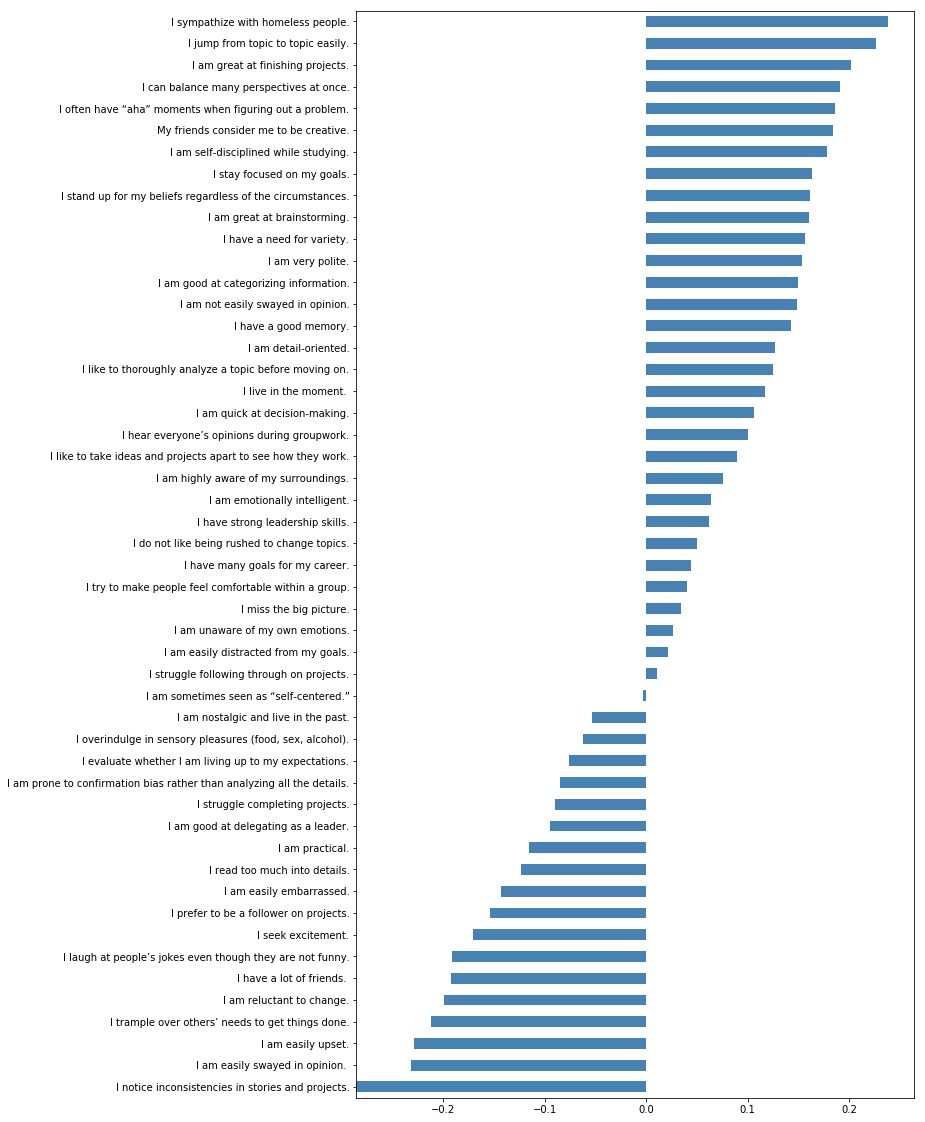

In [67]:
# How questions correlate with age

data.select_dtypes('number').corrwith(age).sort_values().plot.barh(color='steelblue', figsize=(10,20))

In [82]:
data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Chinese', 'Asian', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Filipino', 'Asian', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Caucasian', 'White', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Salvadoran', 'Latino', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Burmese', 'Asian', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Mexican', 'Latino', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Burmese/Chinese', 'Asian', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Guatamalan', 'Latino', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Guatemalan', 'Latino', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Mexican/Nicaraguense', 'Latino', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Filipino/Chinese', 'Asian', data['Ethnicity (Be specific)'])


data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Italian', 'White', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Indonesian', 'Asian', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Vietnamese', 'Asian', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Indian', 'Asian', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Nicaraguense', 'Latino', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'] == 'Tongan', 'Mixed/Other', data['Ethnicity (Be specific)'])

data['Ethnicity (Be specific)'] =\
np.where(data['Ethnicity (Be specific)'].str.contains('/'), 'Mixed/Other', data['Ethnicity (Be specific)'])


In [87]:
# Keep in mind you only have one black person!
ethnicities = data.groupby('Ethnicity (Be specific)').mean()

In [88]:
ethnicities[[i for i in ethnicities.columns[:10]]]

,I try to make people feel comfortable within a group.,I laugh at people’s jokes even though they are not funny.,I am very polite.,I am easily swayed in opinion.,I am unaware of my own emotions.,I am emotionally intelligent.,I evaluate whether I am living up to my expectations.,I stand up for my beliefs regardless of the circumstances.,I am sometimes seen as “self-centered.”,I am not easily swayed in opinion.
Ethnicity (Be specific),,,,,,,,,,
Asian,5.787,4.362,5.617,3.426,3.021,5.191,5.319,5.319,3.426,4.617
Black,5.000,6.000,6.000,2.000,1.000,6.000,5.000,6.000,2.000,6.000
Latino,5.538,3.615,6.000,3.692,3.308,5.231,5.615,5.308,4.077,4.308
Mixed/Other,6.143,4.714,6.857,3.429,2.571,6.000,5.143,4.429,2.429,4.143
White,6.429,4.571,6.286,4.000,2.857,6.000,5.571,4.857,2.857,4.143


In [89]:
ethnicities[[i for i in ethnicities.columns[10:20]]]

,I am practical.,I live in the moment.,"I overindulge in sensory pleasures (food, sex, alcohol).",I am highly aware of my surroundings.,I miss the big picture.,I am nostalgic and live in the past.,I am detail-oriented.,I have a good memory.,I am reluctant to change.,I read too much into details.
Ethnicity (Be specific),,,,,,,,,,
Asian,5.489,4.872,4.064,5.532,2.830,3.511,5.213,5.000,3.766,4.511
Black,5.000,5.000,6.000,4.000,2.000,2.000,5.000,1.000,3.000,7.000
Latino,5.692,4.846,5.077,5.077,3.923,3.769,4.923,4.462,4.154,3.923
Mixed/Other,6.143,4.429,4.429,6.286,2.857,3.857,5.429,5.286,3.000,4.286
White,4.143,4.286,4.429,5.000,3.571,4.429,5.000,4.429,4.286,5.857


In [90]:
ethnicities[[i for i in ethnicities.columns[20:30]]]

,I am great at brainstorming.,I can balance many perspectives at once.,I am easily distracted from my goals.,I struggle completing projects.,I jump from topic to topic easily.,I often have “aha” moments when figuring out a problem.,I like to thoroughly analyze a topic before moving on.,I am prone to confirmation bias rather than analyzing all the details.,I do not like being rushed to change topics.,I stay focused on my goals.
Ethnicity (Be specific),,,,,,,,,,
Asian,5.255,5.277,3.213,2.872,4.489,5.064,5.085,3.426,4.745,5.319
Black,4.000,7.000,2.000,5.000,6.000,7.000,7.000,6.000,6.000,5.000
Latino,5.077,4.923,4.077,3.923,4.462,5.615,5.769,4.154,5.077,5.308
Mixed/Other,5.571,5.571,3.571,3.429,4.286,5.714,5.429,3.429,4.143,4.714
White,5.714,5.286,3.000,2.714,6.000,6.286,4.571,3.286,4.286,5.286


In [91]:
ethnicities[[i for i in ethnicities.columns[30:40]]]

,I am great at finishing projects.,I am good at delegating as a leader.,I have strong leadership skills.,I am quick at decision-making.,I trample over others’ needs to get things done.,I struggle following through on projects.,I prefer to be a follower on projects.,I notice inconsistencies in stories and projects.,I am good at categorizing information.,I like to take ideas and projects apart to see how they work.
Ethnicity (Be specific),,,,,,,,,,
Asian,5.298,5.128,5.064,4.489,2.872,2.979,3.362,5.128,5.532,4.766
Black,2.000,4.000,7.000,5.000,3.000,3.000,7.000,4.000,3.000,4.000
Latino,5.077,5.462,5.615,5.462,4.154,3.538,3.846,4.385,5.308,5.538
Mixed/Other,4.571,4.143,4.857,4.429,2.143,3.143,3.714,5.286,5.714,4.286
White,5.143,4.714,5.286,4.429,2.143,4.143,2.429,4.857,4.714,5.000


In [92]:
ethnicities[[i for i in ethnicities.columns[40:50]]]

,My friends consider me to be creative.,I have a need for variety.,I am self-disciplined while studying.,I have many goals for my career.,I seek excitement.,I have a lot of friends.,I sympathize with homeless people.,I hear everyone’s opinions during groupwork.,I am easily upset.,I am easily embarrassed.
Ethnicity (Be specific),,,,,,,,,,
Asian,4.915,4.957,4.447,5.277,5.553,4.681,4.957,5.809,3.489,4.511
Black,5.000,6.000,1.000,7.000,6.000,7.000,4.000,6.000,3.000,4.000
Latino,4.692,6.000,5.000,6.308,5.154,4.846,4.923,5.308,3.923,3.538
Mixed/Other,4.714,5.000,3.857,5.857,5.857,3.857,5.429,5.714,3.143,4.286
White,5.571,4.857,4.429,6.000,5.143,4.429,5.571,6.000,4.857,3.571


In [97]:
data.query('Age > 20')

,Timestamp,Name (First and Last),Email,Gender,Age,Ethnicity (Be specific),I try to make people feel comfortable within a group.,I laugh at people’s jokes even though they are not funny.,I am very polite.,I am easily swayed in opinion.,...,My friends consider me to be creative.,I have a need for variety.,I am self-disciplined while studying.,I have many goals for my career.,I seek excitement.,I have a lot of friends.,I sympathize with homeless people.,I hear everyone’s opinions during groupwork.,I am easily upset.,I am easily embarrassed.
2,2017/10/02 5:56:11 PM PDT,Albert Ramos,NaN,Male,25,Filipino/Polynesian,6,5,7,1,...,2,6,5,6,5,4,5,7,1,4
6,2017/10/02 10:20:46 PM PDT,James,NaN,Male,21,Indonesian,7,4,7,4,...,2,5,7,7,3,4,6,7,2,7
7,2017/10/02 10:21:40 PM PDT,Timothy Lam,NaN,Male,21,Chinese,4,7,5,6,...,2,5,6,5,5,3,4,3,2,6
9,2017/10/02 10:23:08 PM PDT,May,NaN,Female,21,Chinese,5,5,6,4,...,3,4,5,5,6,3,4,6,4,5
10,2017/10/02 10:31:21 PM PDT,Kaung Yang,NaN,Male,21,Burmese/Chinese,5,5,4,2,...,4,4,5,4,5,3,4,6,1,5
11,2017/10/02 10:33:12 PM PDT,Norman Leung,NaN,Male,21,Chinese,1,3,6,2,...,1,5,4,1,5,1,2,3,5,5
12,2017/10/02 10:38:50 PM PDT,ernest chan,NaN,Male,22,Chinese,5,2,5,1,...,5,5,6,5,5,4,1,5,3,3
13,2017/10/02 10:52:14 PM PDT,Justin Tom,NaN,Male,21,Chinese,5,5,5,3,...,4,5,5,5,5,5,6,5,3,5
16,2017/10/02 11:28:57 PM PDT,Nikki Landayan,NaN,Female,21,Filipino,6,6,7,5,...,6,6,4,3,4,5,6,6,6,6
17,2017/10/02 11:35:05 PM PDT,Aung Hein,NaN,Male,25,Burmese,7,4,5,4,...,6,2,5,5,7,7,1,7,5,7
